<a href="https://colab.research.google.com/github/shivagowri1928/LifeExpectancyProject/blob/main/Life_Expectancy(WHO)ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'life-expectancy-who:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F12603%2F17232%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240226%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240226T062312Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3ca489dc091d136d29f6dd09a0bb668c6cd417f5a01d4a054f4aa0320d5eb18cec305d95d794350223d25ba889754c88c232923fcd84c4acd3b0b686be1c9a8c68f72326d8de7d5464c453c376bd5226cf1d8cadb6314bc95c8ab7d92450c0371c56daf110f82440b3a7d8ac1e5bc26d67b87b3e9f80734bf9810b6800d9b75aa1aed4979d4f58280b27bd8b66b77ff2c6417642938ba389dbf4ea277b47a5c48bd077c9a6cc8ce3cb9b7da3c5a2fa6c8fcb2f6004b5432db0c7ce3448996e72008a9681a3956aece65324c8bb16fefa6d378615c8e00d135f48578adf5011ce7db48aca400f65d0ae6af88168ad343ad63881d6baa3e750020df64b442f2d93'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 121472 bytes downloaded
Downloaded and uncompressed: life-expectancy-who
Data source import complete.


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score         # we are using this for model tunning

from warnings import filterwarnings
filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/life-expectancy-who/Life Expectancy Data.csv


In [5]:
Life_Expectancy_Data = pd.read_csv("../input/life-expectancy-who/Life Expectancy Data.csv")
data = Life_Expectancy_Data.copy()
data = data.dropna()     # If there is a missing or empty observation, delete it. Or 'data.fillna(data.mean(), inplace=True)' with this make NaN values take mean

lindata = data.copy()
multidata = data.copy()
polydata = data.copy()
RFdata = data.copy()
logdata = data.copy()

# Linear Regression

In [6]:
lindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1649 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1649 non-null   object 
 1   Year                             1649 non-null   int64  
 2   Status                           1649 non-null   object 
 3   Life expectancy                  1649 non-null   float64
 4   Adult Mortality                  1649 non-null   float64
 5   infant deaths                    1649 non-null   int64  
 6   Alcohol                          1649 non-null   float64
 7   percentage expenditure           1649 non-null   float64
 8   Hepatitis B                      1649 non-null   float64
 9   Measles                          1649 non-null   int64  
 10   BMI                             1649 non-null   float64
 11  under-five deaths                1649 non-null   int64  
 12  Polio               

In [7]:
lindata.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [8]:
lindata.corr()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1.000000,0.050771,-0.037092,0.008029,-0.113365,0.069553,0.114897,-0.053822,0.005739,0.010479,-0.016699,0.059493,0.029641,-0.123405,0.096421,0.012567,0.019757,0.014122,0.122892,0.088732
Life expectancy,0.050771,1.000000,-0.702523,-0.169074,0.402718,0.409631,0.199935,-0.068881,0.542042,-0.192265,0.327294,0.174718,0.341331,-0.592236,0.441322,-0.022305,-0.457838,-0.457508,0.721083,0.727630
Adult Mortality,-0.037092,-0.702523,1.000000,0.042450,-0.175535,-0.237610,-0.105225,-0.003967,-0.351542,0.060365,-0.199853,-0.085227,-0.191429,0.550691,-0.255035,-0.015012,0.272230,0.286723,-0.442203,-0.421171
infant deaths,0.008029,-0.169074,0.042450,1.000000,-0.106217,-0.090765,-0.231769,0.532680,-0.234425,0.996906,-0.156929,-0.146951,-0.161871,0.007712,-0.098092,0.671758,0.463415,0.461908,-0.134754,-0.214372
Alcohol,-0.113365,0.402718,-0.175535,-0.106217,1.000000,0.417047,0.109889,-0.050110,0.353396,-0.101082,0.240315,0.214885,0.242951,-0.027113,0.443433,-0.028880,-0.403755,-0.386208,0.561074,0.616975
percentage expenditure,0.069553,0.409631,-0.237610,-0.090765,0.417047,1.000000,0.016760,-0.063071,0.242738,-0.092158,0.128626,0.183872,0.134813,-0.095085,0.959299,-0.016792,-0.255035,-0.255635,0.402170,0.422088
Hepatitis B,0.114897,0.199935,-0.105225,-0.231769,0.109889,0.016760,1.000000,-0.124800,0.143302,-0.240766,0.463331,0.113327,0.588990,-0.094802,0.041850,-0.129723,-0.129406,-0.133251,0.184921,0.215182
Measles,-0.053822,-0.068881,-0.003967,0.532680,-0.050110,-0.063071,-0.124800,1.000000,-0.153245,0.517506,-0.057850,-0.113583,-0.058606,-0.003522,-0.064768,0.321946,0.180642,0.174946,-0.058277,-0.115660
BMI,0.005739,0.542042,-0.351542,-0.234425,0.353396,0.242738,0.143302,-0.153245,1.000000,-0.242137,0.186268,0.189469,0.176295,-0.210897,0.266114,-0.081416,-0.547018,-0.554094,0.510505,0.554844
under-five deaths,0.010479,-0.192265,0.060365,0.996906,-0.101082,-0.092158,-0.240766,0.517506,-0.242137,1.000000,-0.171164,-0.145803,-0.178448,0.019476,-0.100331,0.658680,0.464785,0.462289,-0.148097,-0.226013


Looking at heatmap, there is a good relationship (correlation exists) between the best 'GDP' and 'percentage expenditure' in the Life Expectation data.


In [9]:
# plot the heatmap
corr = lindata.corr()
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns)



NameError: name 'sns' is not defined

Here it is better to establish a linear model between 'GDP' and 'percentage expenditure'. Let's see what our spending percentages are compared to the "GDP" increase. Let's create and fit our linear model.

In [10]:
linear_reg = LinearRegression()
x = lindata.GDP.values.reshape(-1,1)     #In the case of linear regression, the input data typically needs to be in a 2D format
y = lindata['percentage expenditure'].values.reshape(-1,1)

linear_reg.fit(x,y)

LinearRegression()

## y = b0 + b1*x is our linear regression model.
Let's see estimated percentage of expenditure in GDP 10 thousand:

In [11]:
b0 = linear_reg.predict(([[10000]]))
print("b0: ", b0)

b1 = linear_reg.coef_
print("b1: ", b1)

b0:  [[1351.02549826]]
b1:  [[0.14705833]]


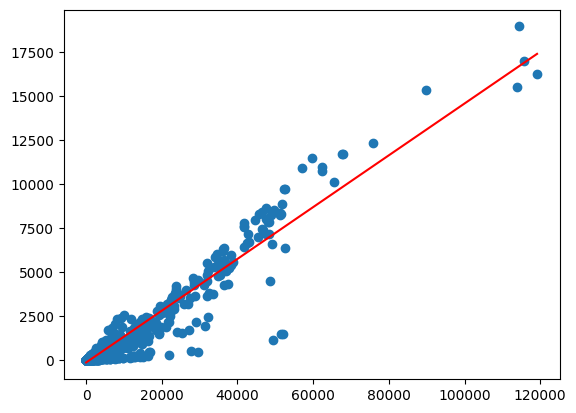

Mean Absolute Error:  50943.94783778519
Mean Squared Error:  3456291221.6604414
Root Mean Squared Error:  58790.230665140625


In [12]:
x_array = np.arange(min(lindata.GDP),max(lindata.GDP)).reshape(-1,1)  # this is for information about the line to be predicted

plt.scatter(x,y)
y_head = linear_reg.predict(x_array)                                 # this is to predict percentage of expenditure
plt.plot(x_array,y_head,color="red")
plt.show()

from sklearn import metrics
print("Mean Absolute Error: ", metrics.mean_absolute_error(x_array,y_head))
print("Mean Squared Error: ", metrics.mean_squared_error(x_array,y_head))
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(x_array, y_head)))



In [13]:
print(r2_score(y, linear_reg.predict(x)))

0.920254296978608


#### The conclusion here is: the estimate made has 92% accuracy.

# Polynomial Regression

We will use the same data set.

In [14]:
from sklearn.preprocessing import PolynomialFeatures     # this gives properties of polynomial

Life_Expectancy_Data = pd.read_csv("../input/life-expectancy-who/Life Expectancy Data.csv")
data = Life_Expectancy_Data.copy()
data = data.dropna()

polydata = data.copy()

Let's see what our spending percentages are compared to the "GDP" increase. Let's create and fit our linear model.

In [15]:
linear_reg = LinearRegression()
x = polydata.GDP.values.reshape(-1,1)
y = polydata['percentage expenditure'].values.reshape(-1,1)

linear_reg.fit(x,y)

LinearRegression()

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state= 42)

Let's look at the 15th degree. If it's not, we should change it.

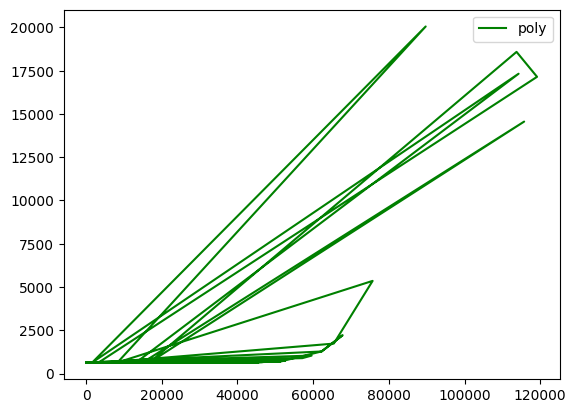

In [17]:
polynomial_regression = PolynomialFeatures(degree = 15)
x_polynomial = polynomial_regression.fit_transform(x)

linear_reg2 = LinearRegression()
linear_reg2.fit(x_polynomial,y)

y_head = linear_reg2.predict(x_polynomial)

plt.plot(x,y_head,color="green",label="poly")
plt.legend()
plt.show()

With degree we determine the precision of our forecast. If it is too large, it will deteriorate, so it is necessary to determine according to the data.

In [18]:
pol_reg = PolynomialFeatures(degree = 8)

level_poly = pol_reg.fit_transform(x_train)                 # According to the polynomial, x_train is defined

lm = LinearRegression()
lm.fit(level_poly,y_train)

LinearRegression()

In [19]:
y_head = lm.predict(pol_reg.fit_transform(x_train))
y_test =np.array(range(0,len(y_train)))

Consistency and scatter drawing of $r^2$ model:

r2 value:  0.6496357950943785


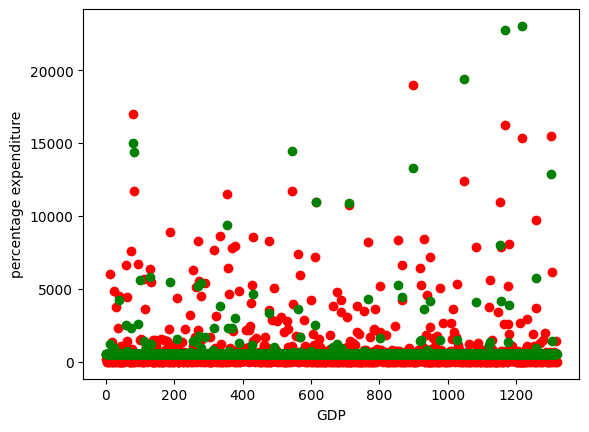

In [20]:
r2 = r2_score(y_train, y_head) #It represents the proportion of variance in the dependent variable
                                #that can be explained by the independent variables in the model.
print("r2 value: ", r2)


plt.scatter(y_test, y_train, color="red")
plt.scatter(y_test, y_head, color = "g")
plt.xlabel("GDP")
plt.ylabel("percentage expenditure")
plt.show()

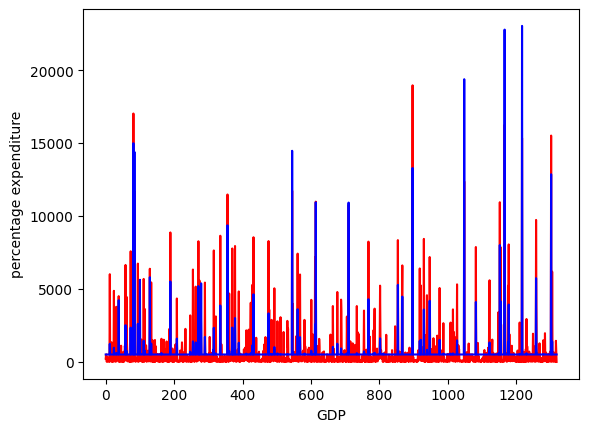

In [21]:
plt.plot(y_test,y_train, color="red")
plt.plot(y_test, y_head, color = "blue")
plt.xlabel("GDP")
plt.ylabel("percentage expenditure")
plt.show()

# Decision Tree Regression

In [22]:
from sklearn.tree import DecisionTreeRegressor               # for our predict model

Life_Expectancy_Data = pd.read_csv("../input/life-expectancy-who/Life Expectancy Data.csv")
data = Life_Expectancy_Data.copy()
data = data.dropna()                                         # same is done

DTdata = data.copy()

In [23]:
x = polydata.GDP.values.reshape(-1,1)
y = polydata['percentage expenditure'].values.reshape(-1,1)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state= 42)

Let's see Expenditure percentage estimation of the country with "GDP" value of 1000:

In [25]:
DT_reg = DecisionTreeRegressor()           # created model
DT_reg.fit(x_train,y_train)                # fitted model according to train values

print(DT_reg.predict([[1000]]))

[98.68367951]


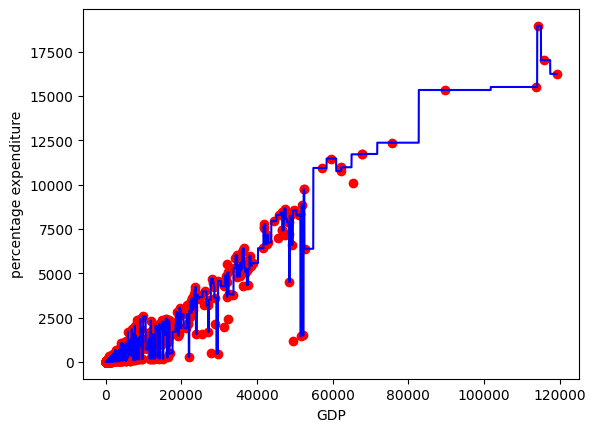

In [26]:
x_array = np.arange(min(x),max(x),0.01).reshape(-1,1)   # line information to be drawn as a predict
y_head = DT_reg.predict(x_array)                        # percentage of spend estimate

plt.scatter(x,y, color="red")
plt.plot(x_array,y_head,color="blue")
plt.xlabel("GDP")
plt.ylabel("percentage expenditure")
plt.show()

In [27]:
from sklearn.ensemble import RandomForestRegressor           # for our predict model

Life_Expectancy_Data = pd.read_csv("../input/life-expectancy-who/Life Expectancy Data.csv")
data = Life_Expectancy_Data.copy()
data = data.dropna()                                         # same is done

RFdata = data.copy()

In [28]:
x = polydata.GDP.values.reshape(-1,1)
y = polydata['percentage expenditure'].values.reshape(-1,1)

Create regression with 5 DecisionTreeReg in the sklearn RandomForestRegressor model. We can do as many as we want. Giving random_state does not change the outcome. When we say 1, it should not change once.

In [29]:
RF_reg = RandomForestRegressor(n_estimators=100, random_state=42)
RF_reg.fit(x,y)                                                # the best fit line is drawn

RandomForestRegressor(random_state=42)

Expenditure percentage estimation of the country with "GDP" value of 1000:

In [30]:
print(RF_reg.predict([[1000]]))

[73.33903837]


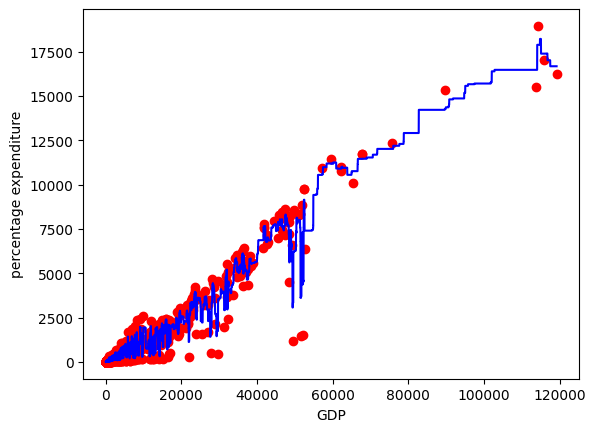

In [31]:
x_array = np.arange(min(x),max(x),0.01).reshape(-1,1)   # line information to be drawn as a predict
y_head = RF_reg.predict(x_array)                        # percentage of spend predict

plt.scatter(x,y, color="red")
plt.plot(x_array,y_head,color="blue")
plt.xlabel("GDP")
plt.ylabel("percentage expenditure")
plt.show()

### Result: This result good but not so good as BEFORE.

# Logistic Regression Model

* The aim is to reveal the class that will occur when a set of x values that have not yet been observed, to predict a classifier.
* For the classification problem, to establish a linear model that defines the relationship between dependent and independent variables.
* Regarding whether the dependent variable is 1 or 0 or yes or no status


** In this data, we will examine the states of Developed countries (Developed) = 0 and Developing = 1. I want to find the level of development I want, so close to 1!

When we look at the country column data, it consists of objects, let's drop it. Because we need int or float values.

In [32]:
logdata.drop(["Country"], axis=1, inplace=True)
logdata.head()

,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Our variable class, which is 1 to 0, let's examine this.

In [33]:
logdata["Status"].value_counts()

Developing    1407
Developed      242
Name: Status, dtype: int64

Let's continue with the review.

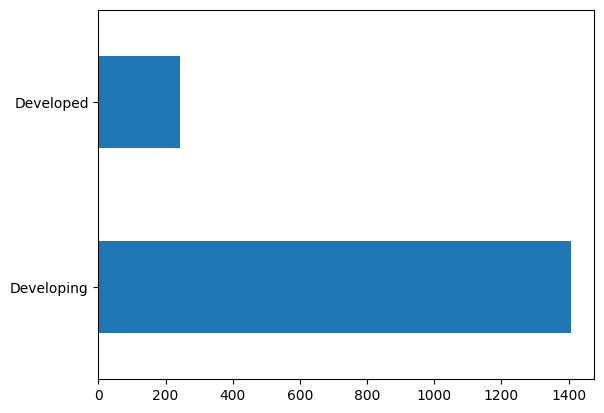

In [34]:
logdata["Status"].value_counts().plot.barh();

We need to create binary, that is, from 0 to 1. Let's do the necessary transformations.

In [35]:
logdata.Status = [1 if each == "Developing" else 0 for each in logdata.Status]

In [36]:
logdata

,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,2015,1,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,2014,1,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,2013,1,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,2012,1,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,2011,1,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,2004,1,44.3,723.0,27,4.36,0.000000,68.0,31,27.1,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,2003,1,44.5,715.0,26,4.06,0.000000,7.0,998,26.7,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,2002,1,44.8,73.0,25,4.43,0.000000,73.0,304,26.3,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,2001,1,45.3,686.0,25,1.72,0.000000,76.0,529,25.9,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


Let's look at their general statistical properties.

In [37]:
logdata.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,1649.0,2.007841e+03,4.087711e+00,2000.00000,2005.000000,2.008000e+03,2.011000e+03,2.015000e+03
Status,1649.0,8.532444e-01,3.539695e-01,0.00000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
Life expectancy,1649.0,6.930230e+01,8.796834e+00,44.00000,64.400000,7.170000e+01,7.500000e+01,8.900000e+01
Adult Mortality,1649.0,1.682153e+02,1.253104e+02,1.00000,77.000000,1.480000e+02,2.270000e+02,7.230000e+02
infant deaths,1649.0,3.255306e+01,1.208472e+02,0.00000,1.000000,3.000000e+00,2.200000e+01,1.600000e+03
Alcohol,1649.0,4.533196e+00,4.029189e+00,0.01000,0.810000,3.790000e+00,7.340000e+00,1.787000e+01
percentage expenditure,1649.0,6.989736e+02,1.759229e+03,0.00000,37.438577,1.451023e+02,5.093900e+02,1.896135e+04
Hepatitis B,1649.0,7.921771e+01,2.560466e+01,2.00000,74.000000,8.900000e+01,9.600000e+01,9.900000e+01
Measles,1649.0,2.224494e+03,1.008580e+04,0.00000,0.000000,1.500000e+01,3.730000e+02,1.314410e+05
BMI,1649.0,3.812862e+01,1.975425e+01,2.00000,19.500000,4.370000e+01,5.580000e+01,7.710000e+01


Let's create our variables now.

In [38]:
y = logdata["Status"]
X_data = logdata.drop(["Status"], axis=1)

In [39]:
X_data

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,2011,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,2004,44.3,723.0,27,4.36,0.000000,68.0,31,27.1,42,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,2003,44.5,715.0,26,4.06,0.000000,7.0,998,26.7,41,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,2002,44.8,73.0,25,4.43,0.000000,73.0,304,26.3,40,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,2001,45.3,686.0,25,1.72,0.000000,76.0,529,25.9,39,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


Let's do normalization in our data.

In [40]:
#*** Normalize ***#

X = (X_data - np.min(X_data))/(np.max(X_data) - np.min(X_data)).values

In [41]:
from sklearn.linear_model import LogisticRegression
loj = LogisticRegression(solver = "liblinear")
loj_model = loj.fit(X,y)
loj_model

LogisticRegression(solver='liblinear')

In [42]:
# constant value
loj_model.intercept_

array([5.83327627])

Coefficient values of all independent variables:

In [43]:
loj_model.coef_

array([[ 1.08208352, -1.39357844,  3.4092507 ,  0.47089776, -5.35962717,
        -0.78837698, -1.44070589,  0.37059599, -0.05002695,  0.43758173,
         0.22862697, -0.10185549,  0.72963257,  0.51727771, -1.44175632,
         0.42676196,  1.95007174,  1.79088634, -1.29839592, -1.92931239]])

# PREDICT and MODEL TUNNING

In [44]:
y_pred = loj_model.predict(X)              # predict

Confusion Matrix: Those that are 1 (PP) when it is 1 in reality, 0 (PN) when it is 1, 1 (NP) when it is 0 when it is 0 (NN) when it is 0.

In [45]:
confusion_matrix(y, y_pred)

array([[ 169,   73],
       [  45, 1362]])

See accuracy score:

In [46]:
accuracy_score(y, y_pred)

0.9284414796846574

One of the outputs that will evaluate the results of a most detailed classification algorithm.

In [47]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74       242
           1       0.95      0.97      0.96      1407

    accuracy                           0.93      1649
   macro avg       0.87      0.83      0.85      1649
weighted avg       0.93      0.93      0.93      1649



See top 10 model predict values:

In [48]:
loj_model.predict(X)[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

* Using the 'predict_proba' module if we want to give the noble values rather than the values given above 1 and 0.


* Returns the values of 0 in the index or left side of 0, and values of 1 in the index 1 or of the right side of the matrix.

In [49]:

loj_model.predict_proba(X)[0:10][:,0:2]                # Top 10

array([[3.37705587e-04, 9.99662294e-01],
       [2.48289180e-04, 9.99751711e-01],
       [2.56463490e-04, 9.99743537e-01],
       [2.56505623e-04, 9.99743494e-01],
       [2.45099743e-04, 9.99754900e-01],
       [2.40236658e-04, 9.99759763e-01],
       [2.28381644e-04, 9.99771618e-01],
       [2.23361824e-04, 9.99776638e-01],
       [2.02091865e-04, 9.99797908e-01],
       [2.15773261e-04, 9.99784227e-01]])

Now let's try to model the ten prediction probability values above 'predict_proba'.

In [50]:

y_probs = loj_model.predict_proba(X)
y_probs = y_probs[:,1]

In [51]:
y_probs[0:10]               # top 10

array([0.99966229, 0.99975171, 0.99974354, 0.99974349, 0.9997549 ,
       0.99975976, 0.99977162, 0.99977664, 0.99979791, 0.99978423])

Put our guess values here in the loop and give it 1 to 0.5 and 0 to the little ones.

In [52]:

y_pred = [1 if i > 0.5 else 0 for i in y_probs]

When we look at the value above, we notice the change. Our purpose to do this is to verify our model.

In [53]:

y_pred[0:10]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [54]:

confusion_matrix(y, y_pred)


array([[ 169,   73],
       [  45, 1362]])

In [55]:
accuracy_score(y, y_pred)

0.9284414796846574

In [56]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74       242
           1       0.95      0.97      0.96      1407

    accuracy                           0.93      1649
   macro avg       0.87      0.83      0.85      1649
weighted avg       0.93      0.93      0.93      1649



Let's do one more look at the top 5 elements we did above.

In [57]:

loj_model.predict_proba(X)[:,1][0:5]

array([0.99966229, 0.99975171, 0.99974354, 0.99974349, 0.9997549 ])

In [58]:
logit_roc_auc = roc_auc_score(y, loj_model.predict(X))

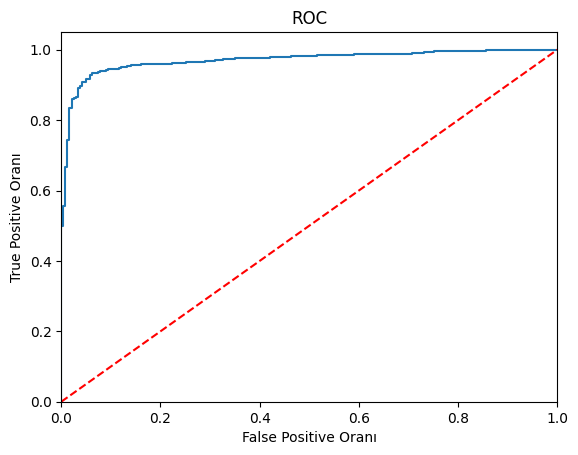

In [59]:
fpr, tpr, thresholds = roc_curve(y, loj_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.title('ROC')
plt.show()


Here,

- blueline: The graphic of our success regarding the model we have established.
- redline: If we don't do anything, our model will be this way.

In [60]:
# test train is subjected to separation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)


# Let's create and fit our model.

In [61]:

loj = LogisticRegression(solver = "liblinear")
loj_model = loj.fit(X_train,y_train)
loj_model



LogisticRegression(solver='liblinear')

Let's see accuracy score:

In [62]:
accuracy_score(y_test, loj_model.predict(X_test))


0.9030303030303031

Finally Tunned model score:

In [63]:
cross_val_score(loj_model, X_test, y_test, cv = 10).mean()


0.8878787878787879

### Result: From this data, we understand: 89% of the countries that are developing are developing countries, and the effects of the variables that will question life expectancies can be examined.